# Vortex Lattice Method

## Point Analysis

In [9]:
!pip install "aerosandbox[full]"



In [41]:
import aerosandbox as asb
import aerosandbox.numpy as np

wing_airfoil = asb.Airfoil("sd7037")
tail_airfoil = asb.Airfoil("naca0010")

### Define the 3D geometry you want to analyze/optimize.
# Here, all distances are in meters and all angles are in degrees.
airplane = asb.Airplane(
    name="Peter's Glider",
    xyz_ref=[0, 0, 0],  # CG location
    wings=[
        asb.Wing(
            name="Main Wing",
            symmetric=True,  # Should this wing be mirrored across the XZ plane?
            xsecs=[  # The wing's cross ("X") sections
                asb.WingXSec(  # Root
                    xyz_le=[0, 0, 0],  # Coordinates of the XSec's leading edge, relative to the wing's leading edge.
                    chord=0.2,
                    twist=2.3,  # degrees
                    airfoil=wing_airfoil,  # Airfoils are blended between a given XSec and the next one.
                ),
                asb.WingXSec(  # Mid
                    xyz_le=[0, 0.5, 0],
                    chord=0.2,
                    twist=2.3,
                    airfoil=wing_airfoil,
                ),
                asb.WingXSec(  # Tip
                    xyz_le=[0, 1, 0.087],
                    chord=0.2,
                    twist=2.3,
                    airfoil=wing_airfoil,
                ),
            ]
        ),
        asb.Wing(
            name="Horizontal Stabilizer",
            symmetric=True,
            xsecs=[
                asb.WingXSec(  # root
                    xyz_le=[0, 0, 0],
                    chord=0.15,
                    twist=0,
                    airfoil=tail_airfoil,
                ),
                asb.WingXSec(  # tip
                    xyz_le=[0.04, 0.2, 0.2],
                    chord=0.15-0.04,
                    twist=0,
                    airfoil=tail_airfoil
                )
            ]
        ).translate([1, 0, 0]),
    ],
    fuselages=[
        asb.Fuselage(
            name="Fuselage",
            xsecs=[
                asb.FuselageXSec(
                    xyz_c=[x, 0, -0.04 if x <=0.09 else 0.26*(x-0.09) -0.04 if x <= 0.18 and x > 0.09 else -0.006],  # Adjust z-coordinate for under-wing position
                    radius=0.03 if x <= 0.09 else
                    -0.26*(x-0.09)+0.03 if x <= 0.18 and x > 0.09 else
                    0.006

                )
                for x in np.linspace(0, 1.15, 100)
            ]
        )
    ]

)

In [31]:
vlm = asb.VortexLatticeMethod(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=9,  # m/s
        alpha=0,  # degree
    )
)

You can change the paneling by passing in various parameters to the `VortexLatticeMethod` constructor, or by using `analysis_specific_options` for various components (`Wing`, `WingXSec`, etc.) These options are viewable in the source code.

In [32]:
aero = vlm.run()  # Returns a dictionary
for k, v in aero.items():
    print(f"{k.rjust(4)} : {v}")

 F_g : [ 1.36492365e-01 -9.99522806e-16  9.06480691e+00]
 F_b : (-0.1364923649157618, -9.995228064408343e-16, -9.06480690901976)
 F_w : (-0.1364923649157618, -9.995228064408343e-16, -9.06480690901976)
 M_g : [ 8.10887711e-15 -6.30012895e-01  4.12299259e-15]
 M_b : (-8.108877114664426e-15, -0.630012895382898, -4.122992586583088e-15)
 M_w : (-8.108877114664426e-15, -0.630012895382898, -4.122992586583088e-15)
   L : 9.06480690901976
   D : 0.1364923649157618
   Y : -9.995228064408343e-16
 l_b : -8.108877114664426e-15
 m_b : -0.630012895382898
 n_b : -4.122992586583088e-15
  CL : 0.45321939191065946
  CD : 0.006824302740085487
  CY : -4.9973829898704056e-17
  Cl : -2.0113209614282363e-16
  Cm : -0.1574959423885774
  Cn : -1.0226645805509865e-16


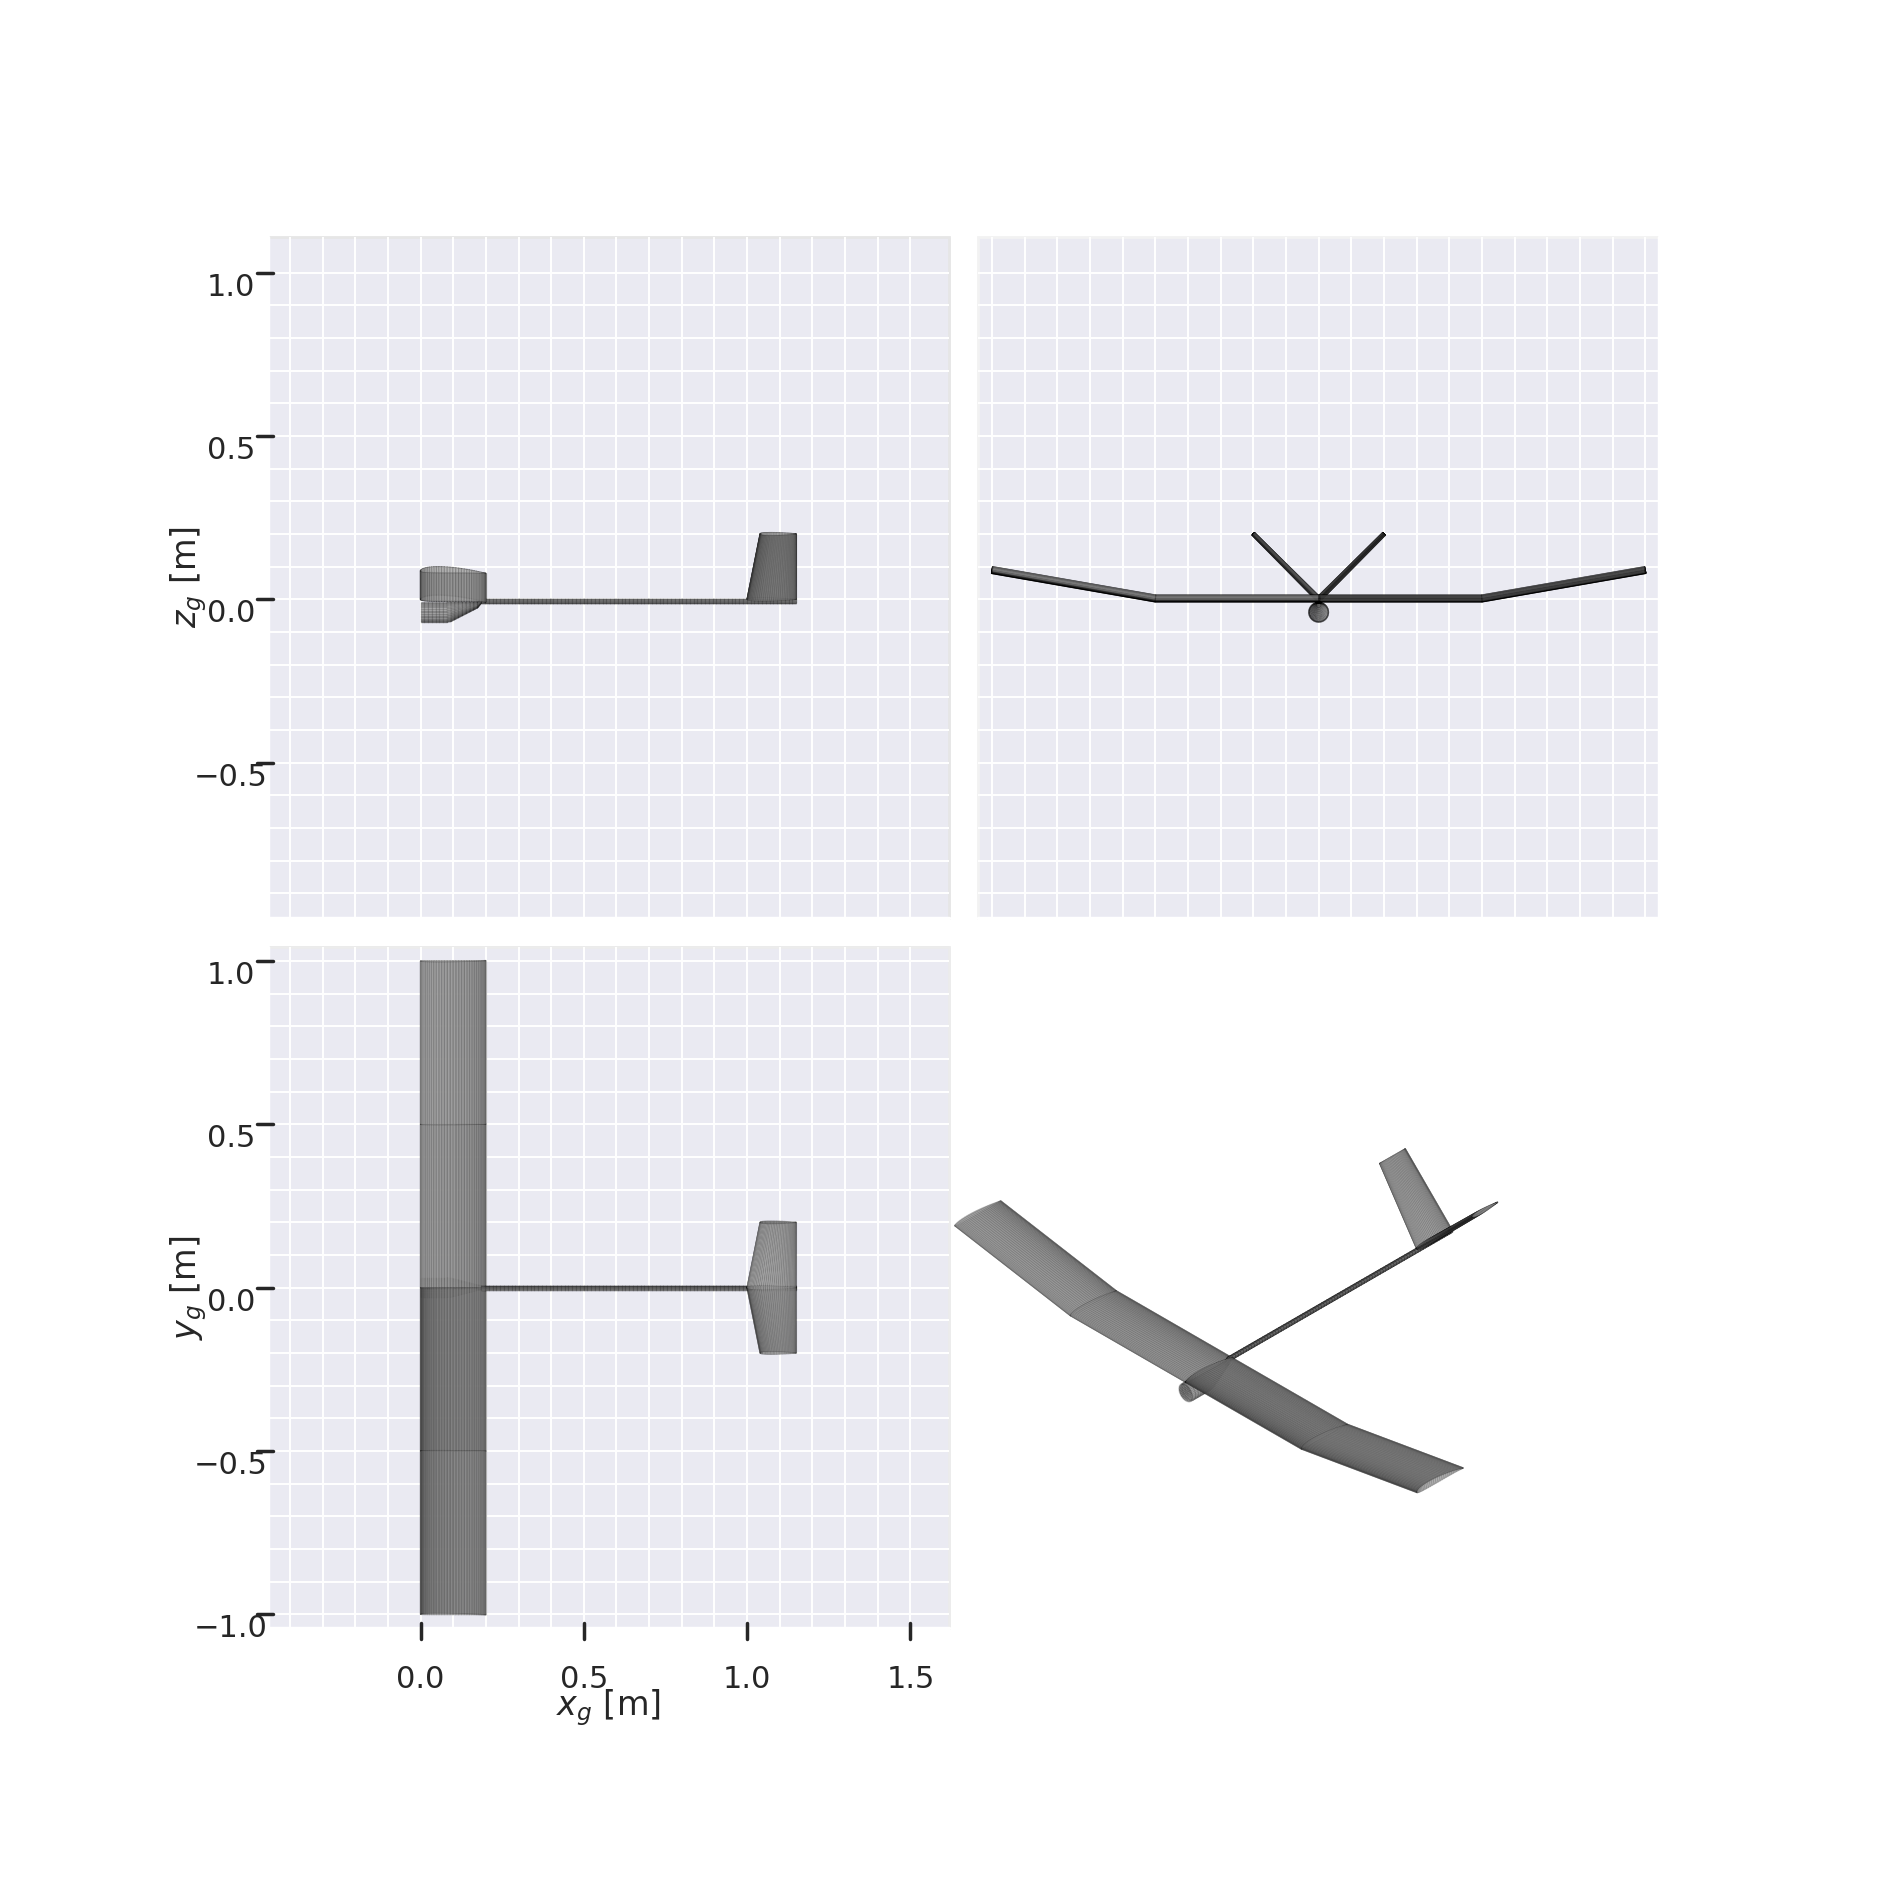

array([[<Axes3D: zlabel='$z_g$ [m]'>, <Axes3D: >],
       [<Axes3D: xlabel='$x_g$ [m]', ylabel='$y_g$ [m]'>, <Axes3D: >]],
      dtype=object)

In [42]:
# NBVAL_SKIP

airplane.draw_three_view()

## Operating Point Optimization

In [14]:
# NBVAL_SKIP
# (This tells our unit tests to skip this cell, as it's a bit wasteful to run on every commit.)

opti = asb.Opti()

alpha = opti.variable(init_guess=5)

vlm = asb.VortexLatticeMethod(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=25,
        alpha=alpha
    ),
    align_trailing_vortices_with_wind=False,
)

aero = vlm.run()

L_over_D = aero["CL"] / aero["CD"]

opti.minimize(-L_over_D)

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -3.4150770e+01 0.00e+00 1.69e+01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [15]:
# NBVAL_SKIP

best_alpha = sol(alpha)
print(f"Alpha for max L/D: {best_alpha:.3f} deg")

Alpha for max L/D: -3.573 deg


## Aerodynamic Shape Optimization

### Minimum Induced Drag (Elliptical Wing)

Let's do some aerodynamic shape optimization, using a classic problem:

Find the wing shape that minimizes induced drag, with the following assumptions:

* A fixed lift
* A fixed wing area
* A fixed wing span
* An untwisted, uncambered, thin, planar wing
* Inviscid, incompressible, irrotational, steady flow

The answer, as any good introductory aerodynamics textbook will teach, is a wing with an elliptical lift distribution. For an untwisted wing (in small angle approximation), this corresponds to an elliptical chord distribution.

Let's pose the problem in AeroSandbox, using the `VortexLatticeMethod` flow solver.

In [16]:
opti = asb.Opti()  # Initialize an optimization environment.

N = 16  # Number of chord sections to optimize

# The y-locations (i.e. span locations) of each section. Note that the span is fixed.
section_y = np.sinspace(0, 1, N, reverse_spacing=True)
# Using `sinspace` gives us better resolution near the wing tip.

We'll use a simple rectangular wing as our initial guess.

In [17]:
chords = opti.variable(init_guess=np.ones(N)) # All chords initially guessed as "1".

wing = asb.Wing(
    symmetric=True,
    xsecs=[
        asb.WingXSec(
            xyz_le=[
                -0.25 * chords[i], # This keeps the quarter-chord-line straight.
                section_y[i], # Our (known) span locations for each section.
                0
            ],
            chord=chords[i],
        )
        for i in range(N)
    ]
)

airplane = asb.Airplane( # Make an airplane object containing only this wing.
    wings=[
        wing
    ]
)

opti.subject_to([  # Let's add some sensible constraints.
    chords > 0,  # Chords should stay positive
    wing.area() == 0.25,  # We want some fixed wing area
])

<ipython-input-17-3ec4f300eb4a>:6: UserWarning: An airfoil is not specified for WingXSec. Defaulting to NACA 0012.
  asb.WingXSec(


[MX(fabs(opti1_lam_g_1)), MX(fabs(opti1_lam_g_2))]

Next, we'll add a constraint that requires the chord distribution to be monotonically decreasing, which is something we know from intuition. We can skip this constraint, but if we do, we need to have more than 1 VLM spanwise section per wing section in order to stabilize the solve (the optimization problem is less-well-posed otherwise, and hence can more easily "fall" into local minima).

In [18]:
opti.subject_to(
    np.diff(chords) <= 0 # The change in chord from one section to the next should be negative.
)

MX(fabs(opti1_lam_g_3))

We don't know the right angle of attack to get the desired lift coefficient a priori, so we'll make that an optimization variable too. Note the easy composability of aerodynamic shape optimization and operating point optimization.

Then, we set up and run the VLM solve.

In [19]:
alpha = opti.variable(init_guess=5, lower_bound=0, upper_bound=30)

op_point = asb.OperatingPoint(
    velocity=1, # Some fixed velocity; doesn't matter since we're working nondimensionally.
    alpha=alpha
)

vlm = asb.VortexLatticeMethod(
    airplane=airplane,
    op_point=op_point,
    spanwise_resolution=1,
    chordwise_resolution=8,
)

aero = vlm.run()

Finally, we add our lift constraint, set the optimization objective to minimize drag, and solve.

In [20]:
# NBVAL_SKIP
# (This tells our unit tests to skip this cell, as it's a bit wasteful to run on every commit.)

opti.subject_to(
    aero["CL"] == 1
)

opti.minimize(aero["CD"])

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       33
Number of nonzeros in inequality constraint Jacobian.:       48
Number of nonzeros in Lagrangian Hessian.............:      153

Total number of variables............................:       17
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total number of inequality constraints...............:       33
        inequality constraints with only lower bounds:       17
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       16

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.5669222e-03 1.75e+00 4.53e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

Let's visualize our solution.

The following command does an in-place substitution of our VLM object, recursively evaluating all its fields from abstract values to concrete ones (i.e., NumPy arrays) at our solution, using our `sol` object.

In [21]:
# NBVAL_SKIP

vlm = sol(vlm)

In [ ]:
# NBVAL_SKIP

vlm.draw(show_kwargs=dict(jupyter_backend="static"))

Looking at our optimized solution, we can compare it to our known analytic solution (an elliptical lift distribution).

In [ ]:
# NBVAL_SKIP

import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

fig, ax = plt.subplots()
plt.plot(
    section_y,
    sol(chords),
    ".-",
    label="AeroSandbox VLM Result",
    zorder=4,
)
y_plot = np.linspace(0, 1, 500)
plt.plot(
    y_plot,
    (1 - y_plot ** 2) ** 0.5 * 4 / np.pi * 0.125,
    label="Elliptic Distribution",
)
p.show_plot(
    "AeroSandbox Drag Optimization using VortexLatticeMethod",
    "Span [m]",
    "Chord [m]"
)


Slight differences arise due to numerical discretization, but it's convergent to the right answer. We can also check the objective function (the induced drag at the minimum):

In [ ]:
# NBVAL_SKIP

AR = 2 ** 2 / 0.25
CL = 1

CDi_theory = CL ** 2 / (np.pi * AR)
CDi_computed = sol(aero["CD"])
print(f"CDi (theory)   : {CDi_theory:.4f}")
print(f"CDi (computed) : {CDi_computed:.4f}")

Essentially matching theory. Both theory and computation are expected to have slight errors compared to the exact potential flow solution:

* The theory side has small errors due to small-angle approximations and simplification of 3D chordwise effects near the tips
* The computational side has small errors due to numerical discretization.

(Both methods neglect thickness effects, too.)